In [1]:
import numpy as np
import matplotlib.pylab as plt

import lichen as lch

# 1-D histograms

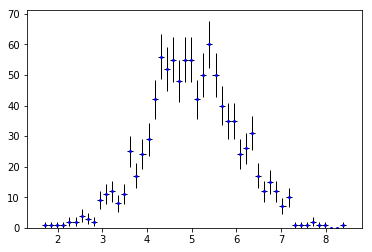

In [2]:
x = np.random.normal(5,1,1000)
h = lch.hist(x,bins=50)
plt.show()

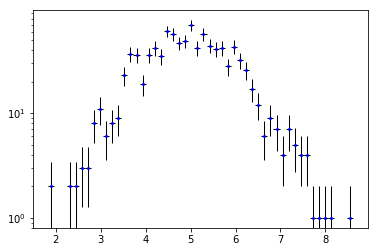

In [3]:
x = np.random.normal(5,1,1000)
h = lch.hist(x,bins=50)
plt.yscale('log')
plt.show()

# 2-D histograms

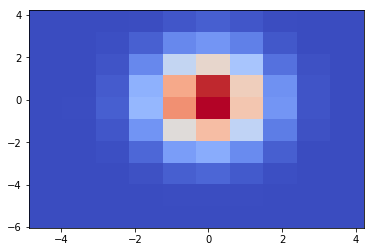

In [4]:
mean = [0, 0]
cov = [[1, 0], [0, 2]]  # diagonal covariance
x, y = np.random.multivariate_normal(mean, cov, 50000).T

h = lch.hist2d(x,y)


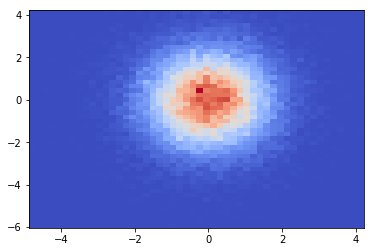

In [5]:
h = lch.hist2d(x,y,xbins=50,ybins=50)


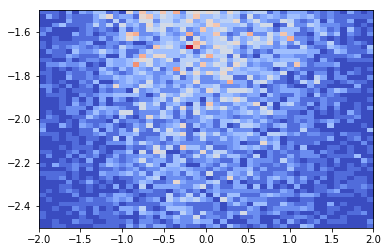

In [6]:
h = lch.hist2d(x,y,xbins=50,ybins=50,xrange=(-2,2),yrange=(-2,-2))
